### Time Signal을 input으로 넣고 Time+PSD를 Loss로 설정
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import windows

import sys
sys.path.append('../../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot
from Scaling import time_scaling, time_inv_scaling

sys.path.append('../../../../tool_code/python_tool_code/frequency_dataset_generation/')
from FFT_func import FFT

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (10000, 4000)
Clean_data.shape: (10000, 4000)


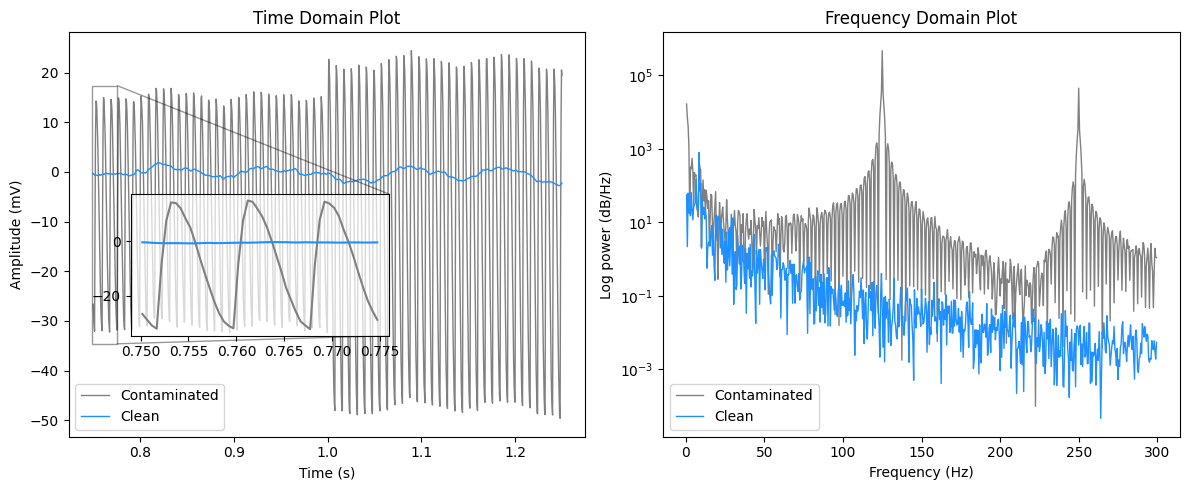

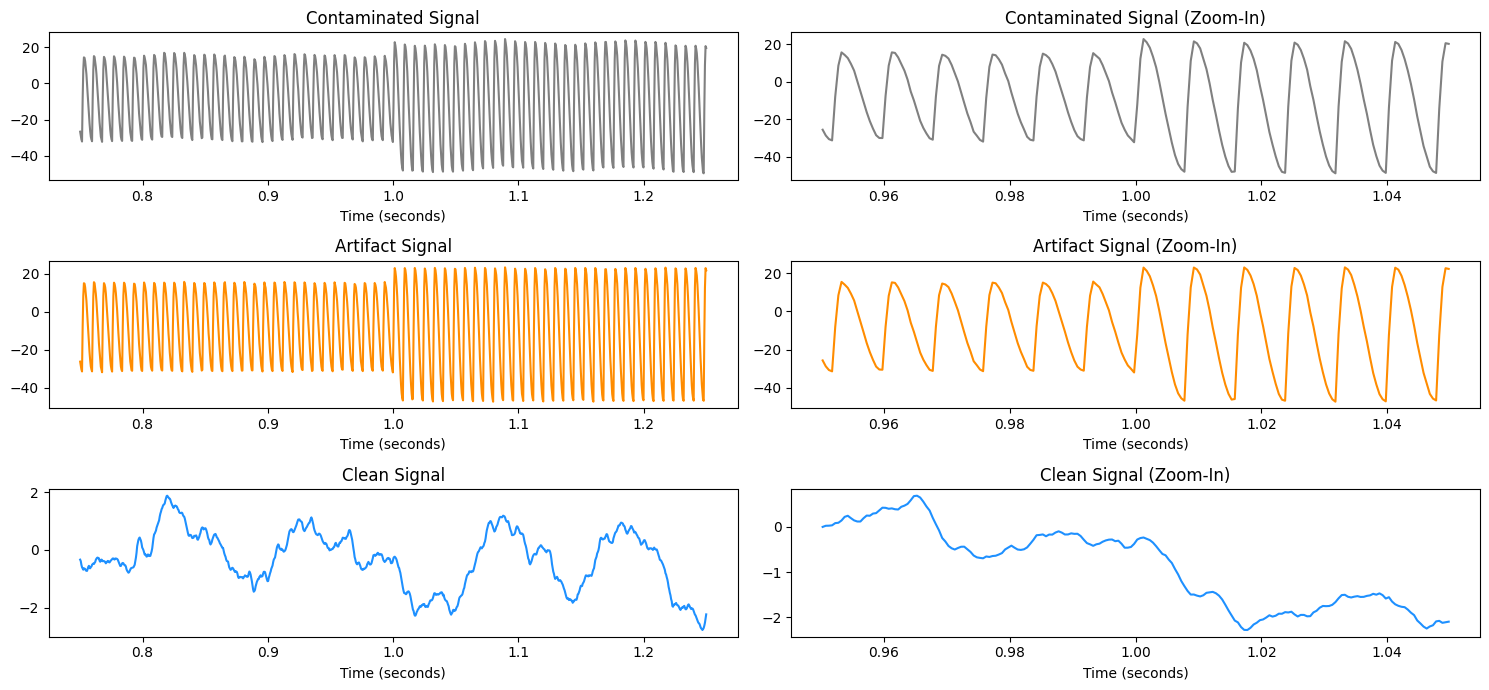

In [4]:
# 데이터 load & plot
datapath='C:/Users/User/Desktop/SCH/10000_data/' 

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [5]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (10000, 4000)
y: (10000, 4000)


In [6]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1]) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (8000, 4000)
y_train shape: (8000, 4000)
-----------------------------
X_test shape: (2000, 4000)
y_test shape: (2000, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (8000, 1, 4000)
y_train shape: (8000, 1, 4000)
-----------------------------
X_test shape: (2000, 1, 4000)
y_test shape: (2000, 1, 4000)
-----------------------------


In [7]:
# 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Conv1d(32, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 1, 3, padding=1)
        )
        
        self.drop = nn.Dropout1d(0.25)

    def forward(self, x): # x : B x 1 x T
        x = self.layer1(x)
        return x

model = CNN().to(device)
print(model)

# 가중치 초기화 함수 정의
def init_weights(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight)  # Xavier 초기화
        if m.bias is not None:
            m.bias.data.fill_(0.01)  # 편향 초기화

# 모델의 가중치 초기화 적용
model.apply(init_weights)

CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): GELU(approximate='none')
    (7): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (drop): Dropout1d(p=0.25, inplace=False)
)


CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): GELU(approximate='none')
    (7): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (drop): Dropout1d(p=0.25, inplace=False)
)

In [8]:
# 손실 함수 정의 

class LossFunction(nn.Module):
    def __init__(self, alpha=0.5):
        super(LossFunction, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

        # 학습 가능한 가중치 파라미터
        self.signal_weight = nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.fft_weight = nn.Parameter(torch.tensor(0.1, requires_grad=True))

    def forward(self, y_pred, y, y_pred_fft, y_fft):
        signal_loss = self.mse_loss(y_pred, y)
        fft_loss = self.mse_loss(y_pred_fft, y_fft)

        # 가중치 적용
        total_loss = self.alpha * (signal_loss * self.signal_weight) + \
                     (1 - self.alpha) * (fft_loss * self.fft_weight)

        return total_loss


In [9]:
# 손실 함수와 옵티마이저 정의
criterion = LossFunction(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 모델 훈련
num_epochs = 500

loss_list = []

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T x 1
        
        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len, _ = y.shape
        y = y.view(batch_size, seq_len, -1)
        y_pred = y_pred.view(batch_size, seq_len, -1)
        
        # Ensure y is a PyTorch tensor and detach it before converting to NumPy
        y_cpu = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else y
        y_pred_cpu = y_pred.detach().cpu().numpy()

        _, _, _, y_fft = FFT(y_cpu, fs=2000, single_sided=True)
        _, _, _, y_pred_fft = FFT(y_pred_cpu, fs=2000, single_sided=True)

        y_pred_fft = torch.tensor(y_pred_fft, dtype=torch.float32).to(y_pred.device)
        y_fft = torch.tensor(y_fft, dtype=torch.float32).to(y.device)

        
        # 배치 크기 불일치 처리
        if y_pred_fft.shape[0] != y_fft.shape[0]:
            min_batch_size = min(y_pred_fft.shape[0], y_fft.shape[0])
            y_pred_fft = y_pred_fft[:min_batch_size]
            y_fft = y_fft[:min_batch_size]

        if y_pred.shape[0] != y.shape[0]:
            min_batch_size = min(y_pred.shape[0], y.shape[0])
            y_pred = y_pred[:min_batch_size]
            y = y[:min_batch_size]

        loss = criterion(y_pred, y, y_pred_fft, y_fft)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(loss.item())
    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')



Epoch 5/500, Loss: 0.00011638538853731006
Epoch 10/500, Loss: 6.993713759584352e-05
Epoch 15/500, Loss: 6.410531204892322e-05
Epoch 20/500, Loss: 6.099802703829482e-05
Epoch 25/500, Loss: 5.75740632484667e-05
Epoch 30/500, Loss: 5.812051676912233e-05
Epoch 35/500, Loss: 6.107273657107726e-05
Epoch 40/500, Loss: 5.309460175340064e-05
Epoch 45/500, Loss: 5.296922608977184e-05
Epoch 50/500, Loss: 5.026273720432073e-05
Epoch 55/500, Loss: 4.8806956328917295e-05
Epoch 60/500, Loss: 4.84874690300785e-05
Epoch 65/500, Loss: 5.154614700586535e-05
Epoch 70/500, Loss: 4.781982715940103e-05
Epoch 75/500, Loss: 4.416651790961623e-05
Epoch 80/500, Loss: 4.959730722475797e-05
Epoch 85/500, Loss: 4.431693014339544e-05
Epoch 90/500, Loss: 4.5057578972773626e-05
Epoch 95/500, Loss: 4.336932033766061e-05
Epoch 100/500, Loss: 4.366826033219695e-05
Epoch 105/500, Loss: 4.4937180064152926e-05
Epoch 110/500, Loss: 4.377292134449817e-05
Epoch 115/500, Loss: 4.389742753119208e-05
Epoch 120/500, Loss: 4.339444

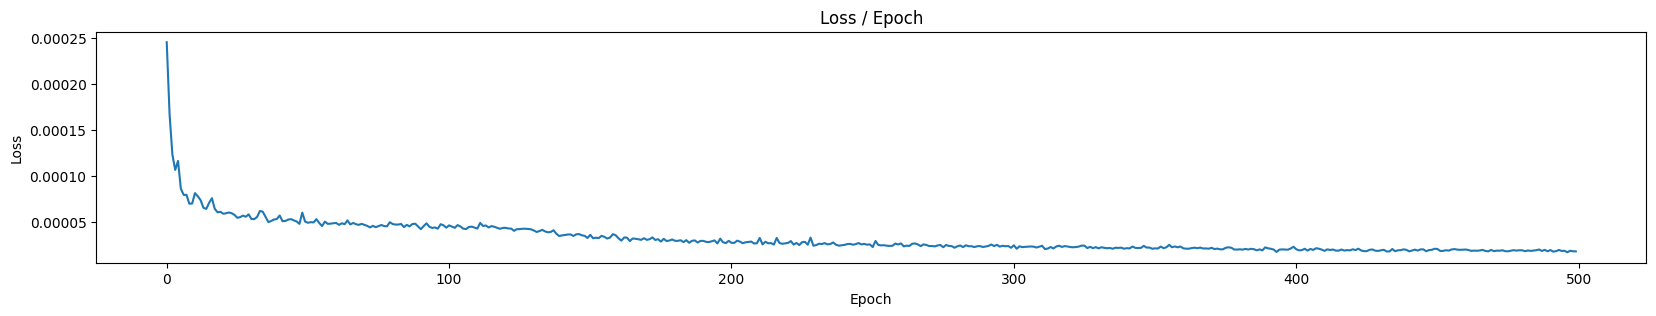

Minimal Loss: 1.6893025531317107e-05 [496]



In [10]:
# Train Loss Plot
Loss_Plot(loss_list)

In [11]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])
SACed_spectro = torch.tensor([])
Clean_spectro = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T

        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len, _ = y.shape
        y = y.view(batch_size, seq_len, -1)
        y_pred = y_pred.view(batch_size, seq_len, -1)
        
        # Ensure y is a PyTorch tensor and detach it before converting to NumPy
        y_cpu = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else y
        y_pred_cpu = y_pred.detach().cpu().numpy()

        _, _, _, y_fft = FFT(y_cpu, fs=2000, single_sided=True)
        _, _, _, y_pred_fft = FFT(y_pred_cpu, fs=2000, single_sided=True)
        
        y_pred_fft = torch.tensor(y_pred_fft, dtype=torch.float32).to(y_pred.device)
        y_fft = torch.tensor(y_fft, dtype=torch.float32).to(y.device)

        # 배치 크기 불일치 처리
        if y_pred_fft.shape[0] != y_fft.shape[0]:
            min_batch_size = min(y_pred_fft.shape[0], y_fft.shape[0])
            y_pred_fft = y_pred_fft[:min_batch_size]
            y_fft = y_fft[:min_batch_size]

        if y_pred.shape[0] != y.shape[0]:
            min_batch_size = min(y_pred.shape[0], y.shape[0])
            y_pred = y_pred[:min_batch_size]
            y = y[:min_batch_size]

        loss = criterion(y_pred, y, y_pred_fft, y_fft)
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)
        SACed_spectro = torch.cat((SACed_spectro, y_pred_fft.cpu()), 0)
        Clean_spectro = torch.cat((Clean_spectro, y_fft.cpu()), 0)

val_loss = criterion(SACed, Clean, SACed_spectro, Clean_spectro)
print(f'Validation Loss: {val_loss.item()}')           

Validation Loss: 1.7788463082979433e-05


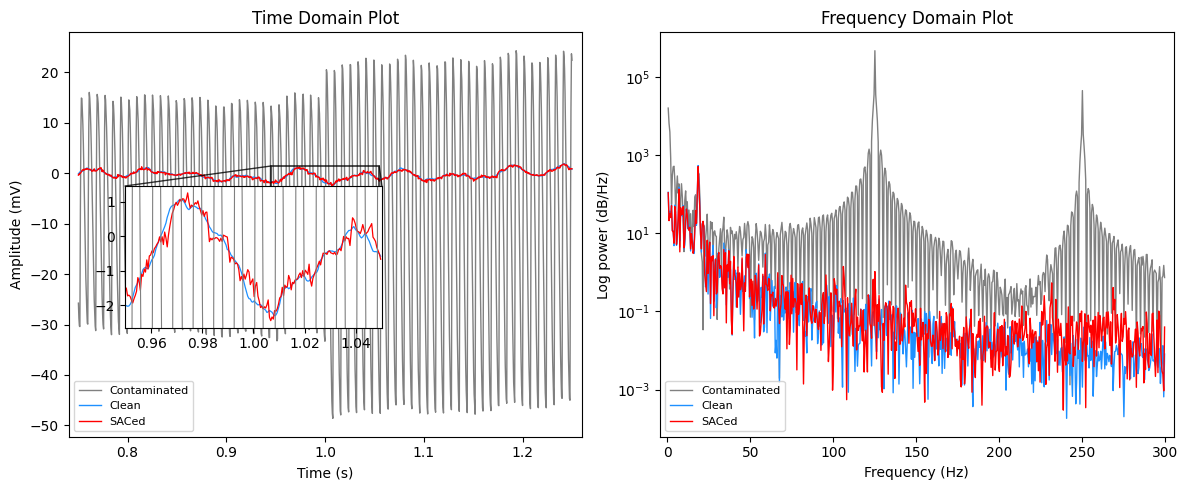

< MSE >
Time Domain MSE: 0.0419805646688002 ± 0.008342171618810495
Frequency Domain MSE: 16.794569410153912 ± 19.137184513563877
Time + Frequency MSE: 7.096413821168077 ± 1.6900547768992444


In [12]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

# 결과 Plot
save_path = '../../../../result/data_10000/CNN/'
save_title = 'CNN_IO_time_L_time-fftPSD'

Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled, save_path, save_title) # inverse scaled data를 input으로 넣음